# Setup and Load Your Specific Data Sheet

In [1]:
# Cell 1: Setup and Load Your Specific Data Sheet

import pandas as pd
import matplotlib.pyplot as plt
import os
from openpyxl import load_workbook

# --- IMPORTANT: Set your Excel file path ---
excel_file_path = r'F:\GP\ML\LiveData\LiveData.xlsx' 

# --- IMPORTANT: Specify the exact sheet name you want to visualize ---
specific_sheet_to_visualize = 'Session_20250605_012926'

# List to hold the single DataFrame for the specified session
sessions_data = [] 

if not os.path.exists(excel_file_path):
    print(f"Error: Excel file not found at '{excel_file_path}'. Please check the path.")
else:
    print(f"Attempting to load data from: '{excel_file_path}'")
    
    try:
        # Load only the specified sheet
        try:
            sheet_df = pd.read_excel(excel_file_path, sheet_name=specific_sheet_to_visualize)
            
            # --- OPTIONAL: Filter out initial spike / bad data ---
            # Remove the very first row (index 0) if it often causes large, artifactual spikes.
            # Only apply if the sheet has more than one row.
            if len(sheet_df) > 1:
                sheet_df = sheet_df.iloc[1:].copy() 
            else:
                print(f"Sheet '{specific_sheet_to_visualize}' has 1 or fewer rows after potential header/spike removal. Skipping.")
                sheet_df = pd.DataFrame() # Make it empty
            
            if not sheet_df.empty:
                # Ensure 'Time (s)' column exists for time-series plotting
                if 'Time (s)' not in sheet_df.columns:
                    print(f"Skipping sheet '{specific_sheet_to_visualize}': 'Time (s)' column not found.")
                    sheet_df = pd.DataFrame() # Make it empty
                else:
                    # For a single session, Cumulative_Time is just Time (s)
                    sheet_df['Cumulative_Time (s)'] = sheet_df['Time (s)'] 
                    sessions_data.append({'name': specific_sheet_to_visualize, 'df': sheet_df})
                    print(f"Successfully loaded sheet '{specific_sheet_to_visualize}'. Rows for plotting: {len(sheet_df)}")
            else:
                print(f"Sheet '{specific_sheet_to_visualize}' is empty or malformed.")

        except Exception as sheet_error:
            print(f"Error loading sheet '{specific_sheet_to_visualize}': {sheet_error}")
            print("Please ensure the sheet name is correct and the sheet exists in the Excel file.")
        
        if not sessions_data: # If the specific sheet was not loaded successfully
            print(f"No valid data loaded from sheet '{specific_sheet_to_visualize}'. Please check your Excel file and sheet name.")
        else:
            print(f"\nSpecified session loaded for plotting: '{specific_sheet_to_visualize}'.")
            
            # Display columns from the loaded session as a reference
            print("\nAvailable columns for plotting (copy these names for Cell 3):")
            print(sessions_data[0]['df'].columns.tolist())
            
    except Exception as e:
        print(f"Error loading Excel file '{excel_file_path}': {e}")
        print("Please ensure the file is a valid .xlsx format and not corrupted/locked.")

# df_combined_for_info (not used for plotting directly in this version, but kept for consistency)
df_combined_for_info = sessions_data[0]['df'] if sessions_data else pd.DataFrame()
if not df_combined_for_info.empty:
    print(f"\nTotal combined rows (for info, not direct plotting): {len(df_combined_for_info)}")

Attempting to load data from: 'F:\GP\ML\LiveData\LiveData.xlsx'
Successfully loaded sheet 'Session_20250605_012926'. Rows for plotting: 404

Specified session loaded for plotting: 'Session_20250605_012926'.

Available columns for plotting (copy these names for Cell 3):
['Index', 'Time (s)', 'TimeWithFace', 'LeftMove(mm)', 'RightMove(mm)', 'LeftVel(mm/s)', 'RightVel(mm/s)', 'LeftFreq(Hz)', 'RightFreq(Hz)', 'LeftAmp(mm)', 'RightAmp(mm)', 'Left_Move_Magnitude_mm', 'Right_Move_Magnitude_mm', 'Left_Vel_Magnitude_mm_s', 'Right_Vel_Magnitude_mm_s', 'Left_Freq_Hz', 'Right_Freq_Hz', 'Left_DX_Norm', 'Left_DY_Norm', 'Left_DZ_Norm', 'Left_VX_Norm', 'Left_VY_Norm', 'Left_VZ_Norm', 'Right_DX_Norm', 'Right_DY_Norm', 'Right_DZ_Norm', 'Right_VX_Norm', 'Right_VY_Norm', 'Right_VZ_Norm', 'Left_DX_Variance', 'Left_DY_Variance', 'Left_DZ_Variance', 'Right_DX_Variance', 'Right_DY_Variance', 'Right_DZ_Variance', 'Left_X_Acceleration_Norm', 'Left_Y_Acceleration_Norm', 'Left_Z_Acceleration_Norm', 'Right_X_Accel

#  Define the Plotting Function (Unchanged)

In [2]:
# Cell 2: Define the Plotting Function

def plot_features_by_session(sessions_list, features_to_plot, title="Eye Movement Features", x_column='Cumulative_Time (s)', figsize=(12, 6)):
    """
    Plots selected features from multiple sessions as line charts, with each session
    plotted as a distinct segment on a potentially cumulative time axis.

    Args:
        sessions_list (list): A list of dictionaries, each containing {'name': str, 'df': pd.DataFrame}.
                              Each DataFrame corresponds to a single session.
        features_to_plot (list): A list of column names (strings) to plot.
        title (str): The title of the plot.
        x_column (str): The column name to use for the x-axis (e.g., 'Cumulative_Time (s)').
        figsize (tuple): Figure size for the plot (width, height).
    """
    
    if not sessions_list:
        print("No sessions data provided for plotting.")
        return

    plt.figure(figsize=figsize)
    plotted_any = False

    for session_info in sessions_list:
        session_name = session_info['name']
        session_df = session_info['df']

        if session_df.empty:
            continue
            
        if x_column not in session_df.columns:
            print(f"Error: X-axis column '{x_column}' not found in DataFrame for session '{session_name}'. Skipping session.")
            continue

        for feature in features_to_plot:
            if feature in session_df.columns:
                # For single session, label can be just the feature name
                label_text = f'{session_name} - {feature}' if len(sessions_list) > 1 else feature
                plt.plot(session_df[x_column], session_df[feature], label=label_text)
                plotted_any = True
            else:
                print(f"Warning: Feature '{feature}' not found in DataFrame for session '{session_name}'. Skipping.")

    if plotted_any:
        plt.title(title)
        plt.xlabel(x_column)
        plt.ylabel("Value")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside for clarity
        plt.grid(True)
        plt.tight_layout() # Adjusts plot parameters for a tight layout
        plt.show()
    else:
        print("No valid features were found to plot across any session.")

# Plotting Examples (Customize These!)


--- Generating Plots ---


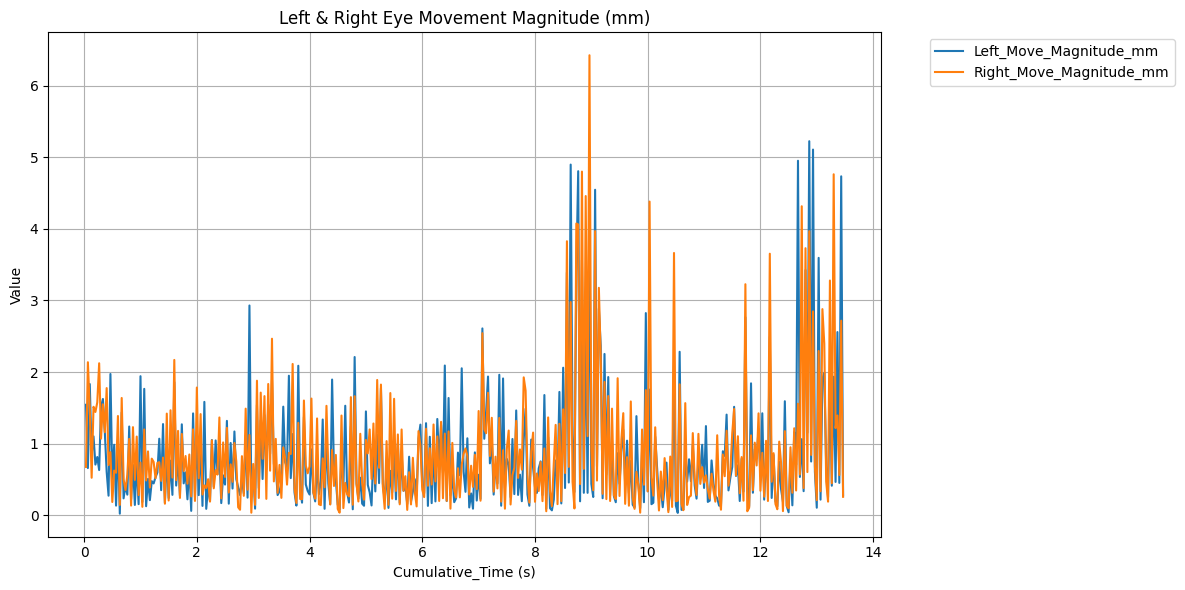

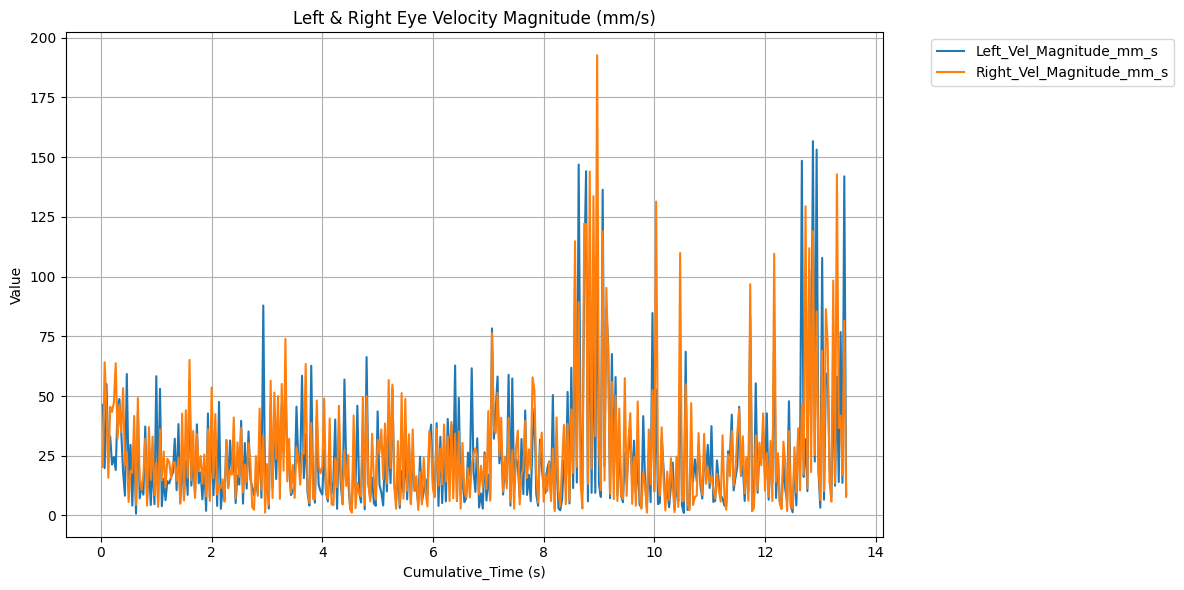

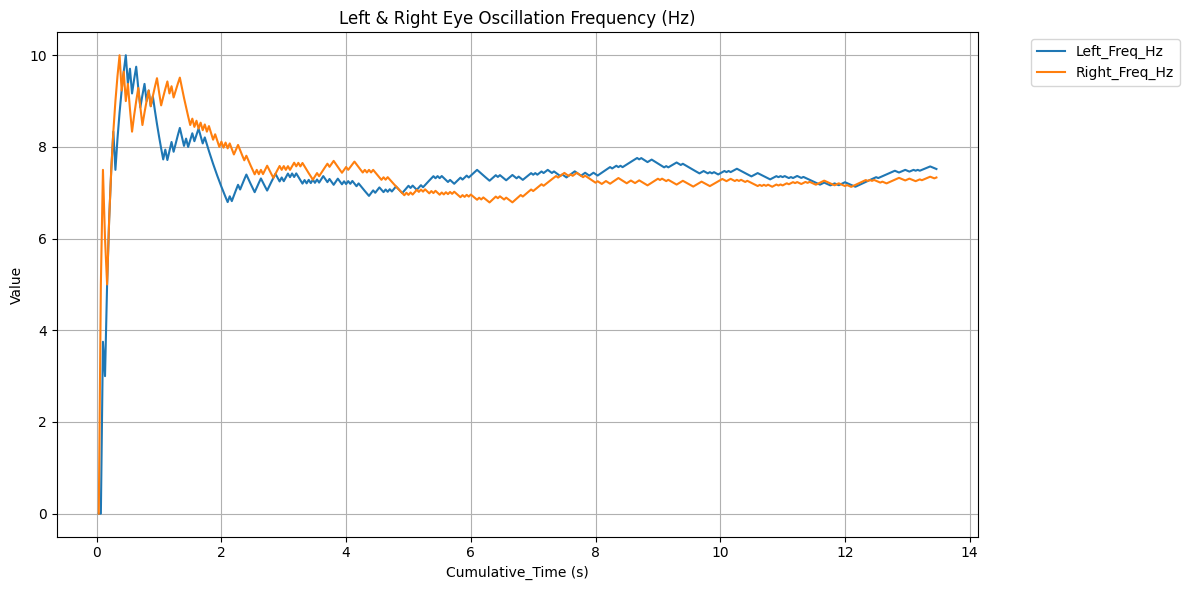

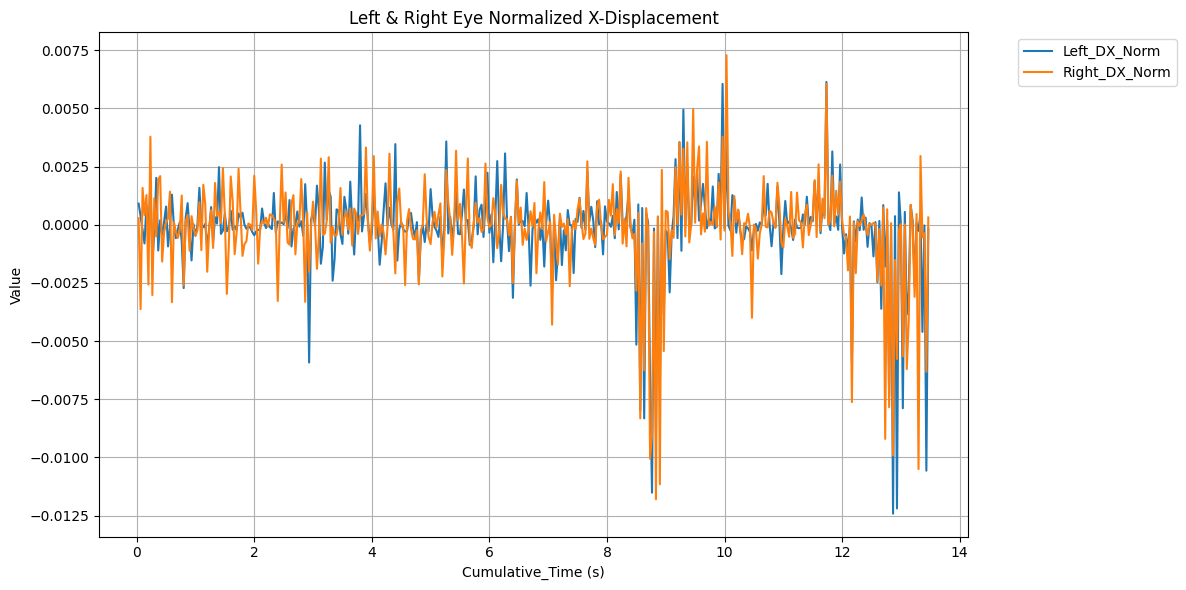

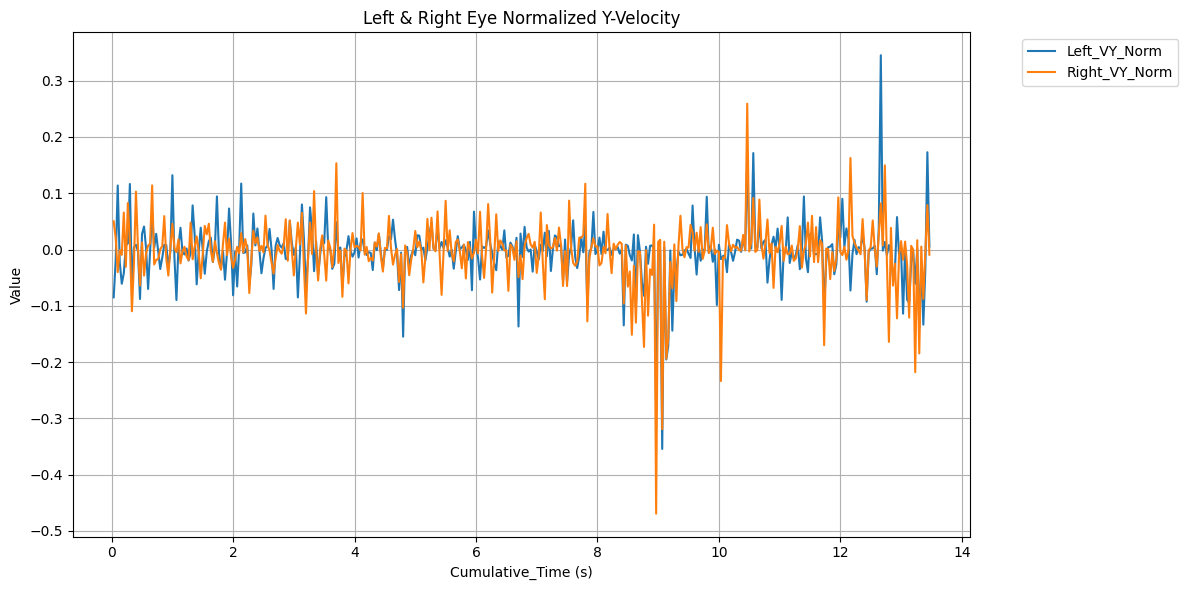

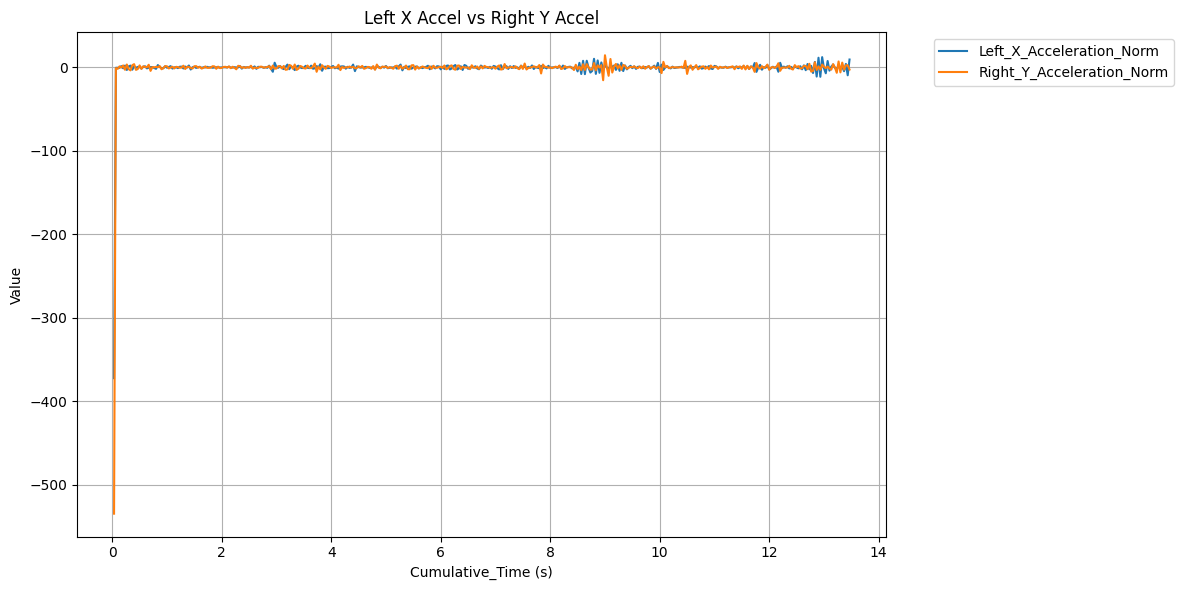

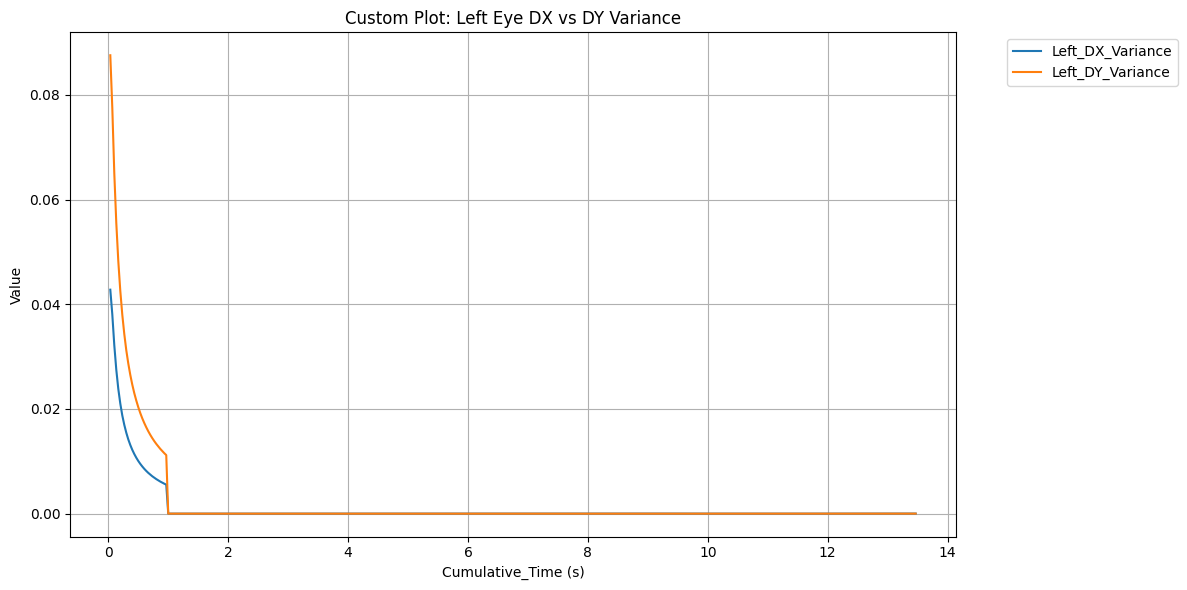


Plotting examples complete. You can modify Cell 3 to plot other combinations of features.


In [3]:
# Cell 3: Plotting Examples (Customize These!)

# Make sure sessions_data list is populated from Cell 1
if not sessions_data:
    print("No sessions data loaded. Please check Cell 1 and your Excel file.")
else:
    print("\n--- Generating Plots ---")

    # --- Example 1: Left and Right Eye Movement Magnitude (mm) ---
    features_move_magnitude = ['Left_Move_Magnitude_mm', 'Right_Move_Magnitude_mm']
    plot_features_by_session(sessions_data, features_move_magnitude, "Left & Right Eye Movement Magnitude (mm)", x_column='Cumulative_Time (s)')

    # --- Example 2: Left and Right Eye Velocity Magnitude (mm/s) ---
    features_vel_magnitude = ['Left_Vel_Magnitude_mm_s', 'Right_Vel_Magnitude_mm_s']
    plot_features_by_session(sessions_data, features_vel_magnitude, "Left & Right Eye Velocity Magnitude (mm/s)", x_column='Cumulative_Time (s)')

    # --- Example 3: Left and Right Eye Oscillation Frequency (Hz) ---
    features_frequency = ['Left_Freq_Hz', 'Right_Freq_Hz']
    plot_features_by_session(sessions_data, features_frequency, "Left & Right Eye Oscillation Frequency (Hz)", x_column='Cumulative_Time (s)')

    # --- Example 4: Normalized X-Displacement for Left & Right Eye ---
    features_dx_norm = ['Left_DX_Norm', 'Right_DX_Norm']
    plot_features_by_session(sessions_data, features_dx_norm, "Left & Right Eye Normalized X-Displacement", x_column='Cumulative_Time (s)')

    # --- Example 5: Normalized Y-Velocity for Left & Right Eye ---
    features_vy_norm = ['Left_VY_Norm', 'Right_VY_Norm']
    plot_features_by_session(sessions_data, features_vy_norm, "Left & Right Eye Normalized Y-Velocity", x_column='Cumulative_Time (s)')
    
    # --- Example 6: Compare specific Accel features ---
    features_accel = ['Left_X_Acceleration_Norm', 'Right_Y_Acceleration_Norm']
    plot_features_by_session(sessions_data, features_accel, "Left X Accel vs Right Y Accel", x_column='Cumulative_Time (s)')

    # --- Example 7: Custom Plot - CHOOSE YOUR OWN FEATURES! ---
    # Look at the "Available columns for plotting" output from Cell 1.
    # Replace the list below with any column names you want to visualize together.
    # Example: Plotting Left_DX_Variance and Left_DY_Variance
    features_custom = ['Left_DX_Variance', 'Left_DY_Variance']
    plot_features_by_session(sessions_data, features_custom, "Custom Plot: Left Eye DX vs DY Variance", x_column='Cumulative_Time (s)')
    
    # Example: Plotting 'TimeWithFace' and 'Label' (if you want to see labeled segments)
    # Note: 'Label' is discrete, so a line plot might look odd, but it shows the labeled regions.
    # features_label_check = ['TimeWithFace', 'Label']
    # plot_features_by_session(sessions_data, features_label_check, "Time With Face and Label", x_column='Cumulative_Time (s)')

    print("\nPlotting examples complete. You can modify Cell 3 to plot other combinations of features.")